# E-commerce Data Analysis

## Table of Contents

1. [Introduction & Business Objectives](#introduction)
2. [Data Dictionary](#data-dictionary)
3. [Configuration & Setup](#configuration)
4. [Data Loading & Preparation](#data-loading)
5. [Business Metrics Analysis](#business-metrics)
   - [Revenue Analysis](#revenue-analysis)
   - [Order Performance](#order-performance)
   - [Product Category Analysis](#product-analysis)
   - [Geographic Distribution](#geographic-analysis)
   - [Customer Experience Metrics](#customer-experience)
6. [Key Insights & Summary](#summary)

## 1. Introduction & Business Objectives <a id='introduction'></a>

This analysis examines e-commerce performance metrics to understand business health and identify growth opportunities. The analysis covers:

**Key Business Questions:**
- How is revenue trending year-over-year and month-over-month?
- What are the top-performing product categories?
- Which geographic regions drive the most revenue?
- How does delivery performance impact customer satisfaction?
- What is the overall customer experience as measured by reviews?

**Analysis Period:** Configurable date range with focus on year-over-year comparisons

## 2. Data Dictionary <a id='data-dictionary'></a>

### Orders Dataset
- **order_id**: Unique identifier for each order
- **customer_id**: Unique identifier for customer
- **order_status**: Current status (delivered, shipped, canceled, processing, pending, returned)
- **order_purchase_timestamp**: Date and time of order placement
- **order_delivered_customer_date**: Actual delivery date to customer
- **order_estimated_delivery_date**: Estimated delivery date at time of purchase

### Order Items Dataset
- **order_id**: Links to orders dataset
- **product_id**: Unique product identifier
- **price**: Item price in USD
- **freight_value**: Shipping cost in USD

### Products Dataset
- **product_id**: Unique product identifier
- **product_category_name**: Product category classification
- **product_weight_g**: Product weight in grams
- **product_dimensions**: Length, height, width in cm

### Customers Dataset
- **customer_id**: Unique customer identifier
- **customer_state**: US state abbreviation
- **customer_city**: City name

### Reviews Dataset
- **order_id**: Links to orders dataset
- **review_score**: Customer rating (1-5 stars)
- **review_comment**: Optional text feedback

## 3. Configuration & Setup <a id='configuration'></a>

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Import custom modules
from data_loader import DataLoader
from business_metrics import BusinessMetrics

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

# Configure visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# Define color scheme for consistent visualizations
COLOR_SCHEME = {
    'primary': '#2E86AB',
    'secondary': '#A23B72',
    'success': '#73AB84',
    'warning': '#F18F01',
    'danger': '#C73E1D',
    'info': '#6C91BF'
}

### Analysis Configuration

Modify these parameters to analyze different time periods:

In [2]:
# CONFIGURATION PARAMETERS - Modify these to change analysis period
ANALYSIS_CONFIG = {
    'current_year': 2023,
    'previous_year': 2022,
    'start_date': '2023-01-01',  # Format: YYYY-MM-DD
    'end_date': '2023-12-31',    # Format: YYYY-MM-DD
    'comparison_start_date': '2022-01-01',
    'comparison_end_date': '2022-12-31'
}

print(f"Analysis Period: {ANALYSIS_CONFIG['start_date']} to {ANALYSIS_CONFIG['end_date']}")
print(f"Comparison Period: {ANALYSIS_CONFIG['comparison_start_date']} to {ANALYSIS_CONFIG['comparison_end_date']}")

Analysis Period: 2023-01-01 to 2023-12-31
Comparison Period: 2022-01-01 to 2022-12-31


## 4. Data Loading & Preparation <a id='data-loading'></a>

In [3]:
# Initialize data loader
loader = DataLoader('ecommerce_data')

# Load all datasets
print("Loading datasets...")
datasets = loader.load_all_datasets()

# Display dataset information
for name, df in datasets.items():
    print(f"\n{name.upper()} dataset:")
    print(f"  Shape: {df.shape}")
    print(f"  Columns: {', '.join(df.columns[:5])}{'...' if len(df.columns) > 5 else ''}")
    print(f"  Memory usage: {df.memory_usage().sum() / 1024**2:.2f} MB")

Loading datasets...

ORDERS dataset:
  Shape: (10000, 10)
  Columns: order_id, customer_id, order_status, order_purchase_timestamp, order_approved_at...
  Memory usage: 0.69 MB

ORDER_ITEMS dataset:
  Shape: (16047, 7)
  Columns: order_id, order_item_id, product_id, seller_id, shipping_limit_date...
  Memory usage: 0.86 MB

PRODUCTS dataset:
  Shape: (6000, 9)
  Columns: product_id, product_category_name, product_name_length, product_description_length, product_photos_qty...
  Memory usage: 0.41 MB

CUSTOMERS dataset:
  Shape: (8000, 5)
  Columns: customer_id, customer_unique_id, customer_zip_code_prefix, customer_city, customer_state
  Memory usage: 0.31 MB

REVIEWS dataset:
  Shape: (6571, 7)
  Columns: review_id, order_id, review_score, review_comment_title, review_comment_message...
  Memory usage: 0.35 MB

PAYMENTS dataset:
  Shape: (14091, 5)
  Columns: order_id, payment_sequential, payment_type, payment_installments, payment_value
  Memory usage: 0.54 MB


### Create Merged Sales Dataset

In [4]:
# Create main analysis dataset for current period
sales_data_current = loader.create_sales_data(
    start_date=ANALYSIS_CONFIG['start_date'],
    end_date=ANALYSIS_CONFIG['end_date'],
    status_filter='delivered'
)

# Create comparison dataset for previous period
sales_data_previous = loader.create_sales_data(
    start_date=ANALYSIS_CONFIG['comparison_start_date'],
    end_date=ANALYSIS_CONFIG['comparison_end_date'],
    status_filter='delivered'
)

# Create combined dataset for year-over-year analysis
sales_data_all = loader.create_sales_data(
    status_filter='delivered'
)

print(f"Current period orders: {sales_data_current['order_id'].nunique():,}")
print(f"Previous period orders: {sales_data_previous['order_id'].nunique():,}")
print(f"Total delivered orders in dataset: {sales_data_all['order_id'].nunique():,}")

Current period orders: 4,625
Previous period orders: 4,741
Total delivered orders in dataset: 9,388


### Merge with Product and Geographic Data

In [5]:
# Add product categories
sales_with_products = loader.create_sales_with_products(
    start_date=ANALYSIS_CONFIG['start_date'],
    end_date=ANALYSIS_CONFIG['end_date']
)

# Add geographic information
sales_with_geography = loader.create_sales_with_geography(
    start_date=ANALYSIS_CONFIG['start_date'],
    end_date=ANALYSIS_CONFIG['end_date']
)

# Merge with reviews for customer experience analysis
sales_with_reviews = pd.merge(
    sales_data_current,
    datasets['reviews'][['order_id', 'review_score']].drop_duplicates(subset=['order_id']),
    on='order_id',
    how='left'
)

print(f"Orders with reviews: {sales_with_reviews['review_score'].notna().sum():,}")
print(f"Review coverage: {sales_with_reviews['review_score'].notna().mean():.1%}")

Orders with reviews: 5,183
Review coverage: 69.7%


## 5. Business Metrics Analysis <a id='business-metrics'></a>

### 5.1 Revenue Analysis <a id='revenue-analysis'></a>

In [6]:
# Initialize metrics calculator
metrics_current = BusinessMetrics(sales_with_reviews)
metrics_all = BusinessMetrics(sales_data_all)

# Calculate year-over-year revenue growth
yoy_revenue = metrics_all.calculate_yoy_growth(
    current_year=ANALYSIS_CONFIG['current_year'],
    previous_year=ANALYSIS_CONFIG['previous_year'],
    metric='revenue'
)

# Display revenue metrics
print(f"Revenue Performance ({ANALYSIS_CONFIG['current_year']} vs {ANALYSIS_CONFIG['previous_year']})")
print("=" * 60)
print(f"Total Revenue {ANALYSIS_CONFIG['current_year']}: ${yoy_revenue['current_value']:,.2f}")
print(f"Total Revenue {ANALYSIS_CONFIG['previous_year']}: ${yoy_revenue['previous_value']:,.2f}")
print(f"Absolute Change: ${yoy_revenue['absolute_change']:,.2f}")
print(f"Growth Rate: {yoy_revenue['growth_rate']:.2f}%")

Revenue Performance (2023 vs 2022)
Total Revenue 2023: $3,360,294.74
Total Revenue 2022: $3,445,076.96
Absolute Change: $-84,782.22
Growth Rate: -2.46%


#### Month-over-Month Revenue Trend

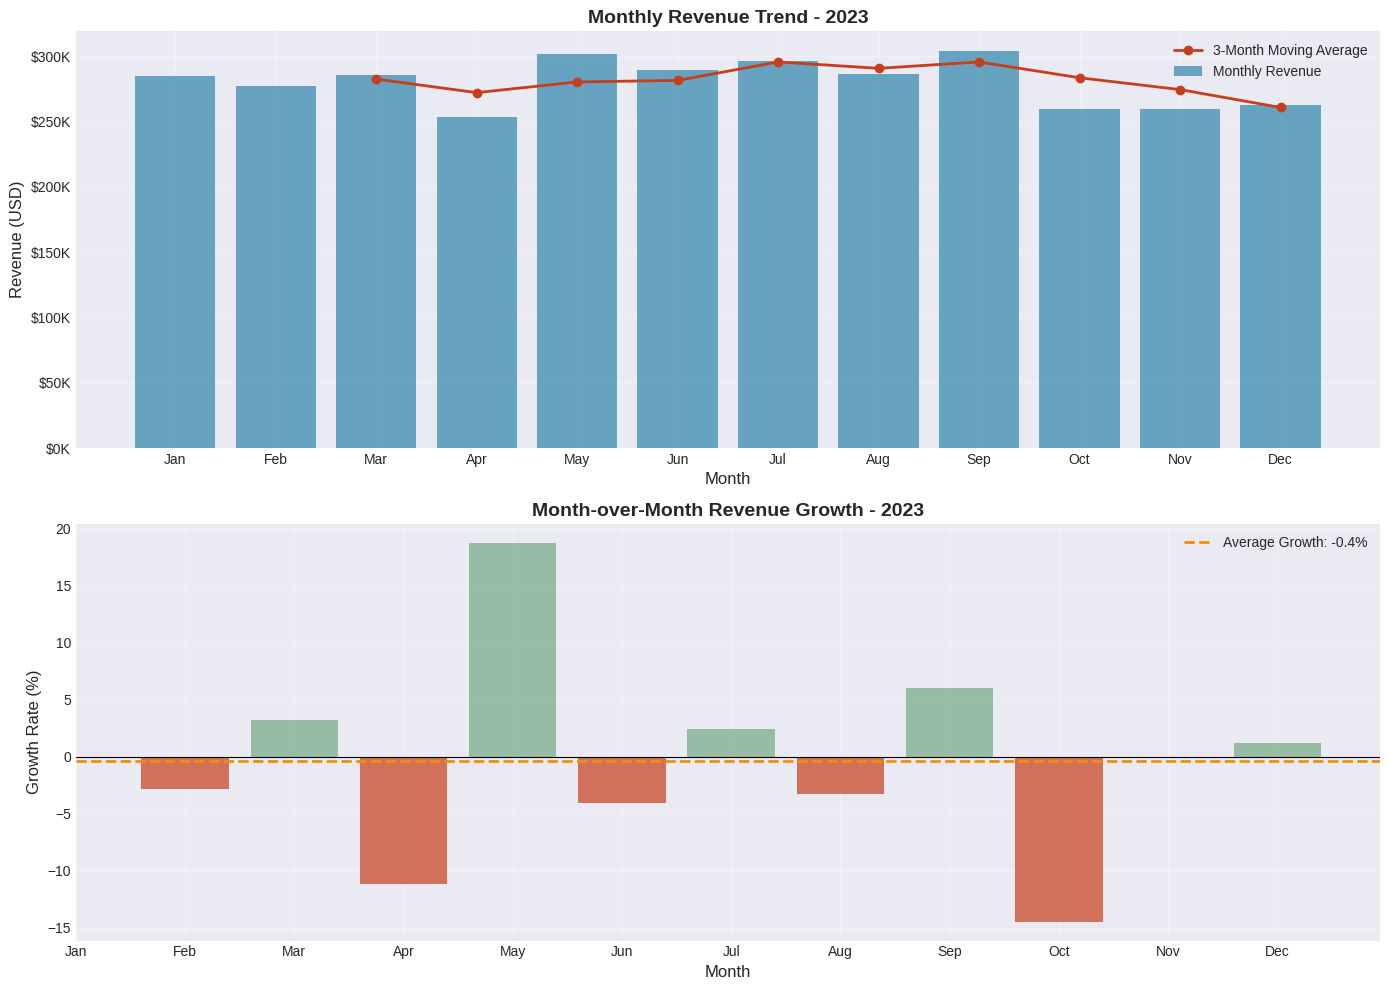


Monthly Revenue Metrics - 2023
month  revenue revenue_mom_growth  order_count avg_order_value
  Jan $284,855                N/A          384         $741.81
  Feb $276,759              -2.8%          384         $720.73
  Mar $285,619               3.2%          394         $724.92
  Apr $253,795             -11.1%          370         $685.93
  May $301,348              18.7%          396         $760.98
  Jun $289,127              -4.1%          406         $712.13
  Jul $296,209               2.4%          392         $755.64
  Aug $286,646              -3.2%          375         $764.39
  Sep $303,793               6.0%          384         $791.13
  Oct $259,890             -14.5%          379         $685.73
  Nov $259,519              -0.1%          384         $675.83
  Dec $262,735               1.2%          387         $678.90


In [7]:
# Calculate monthly metrics
monthly_metrics = metrics_all.calculate_mom_growth(
    year=ANALYSIS_CONFIG['current_year'],
    smoothing=True
)

# Visualize monthly revenue trend
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Revenue trend
ax1 = axes[0]
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
x_pos = monthly_metrics['month'].values

ax1.bar(x_pos, monthly_metrics['revenue'], color=COLOR_SCHEME['primary'], alpha=0.7, label='Monthly Revenue')
ax1.plot(x_pos, monthly_metrics['revenue_ma3'], color=COLOR_SCHEME['danger'], linewidth=2, 
         marker='o', label='3-Month Moving Average')

ax1.set_xlabel('Month', fontsize=12)
ax1.set_ylabel('Revenue (USD)', fontsize=12)
ax1.set_title(f'Monthly Revenue Trend - {ANALYSIS_CONFIG["current_year"]}', fontsize=14, fontweight='bold')
ax1.set_xticks(range(1, 13))
ax1.set_xticklabels(months)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Format y-axis to show values in thousands
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))

# Month-over-month growth rate
ax2 = axes[1]
colors = [COLOR_SCHEME['success'] if x > 0 else COLOR_SCHEME['danger'] 
          for x in monthly_metrics['revenue_mom_growth'].fillna(0)]
ax2.bar(x_pos, monthly_metrics['revenue_mom_growth'], color=colors, alpha=0.7)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax2.set_xlabel('Month', fontsize=12)
ax2.set_ylabel('Growth Rate (%)', fontsize=12)
ax2.set_title(f'Month-over-Month Revenue Growth - {ANALYSIS_CONFIG["current_year"]}', fontsize=14, fontweight='bold')
ax2.set_xticks(range(1, 13))
ax2.set_xticklabels(months)
ax2.grid(True, alpha=0.3)

# Add average growth line
avg_growth = monthly_metrics['revenue_mom_growth'].mean()
ax2.axhline(y=avg_growth, color=COLOR_SCHEME['warning'], linestyle='--', 
            linewidth=2, label=f'Average Growth: {avg_growth:.1f}%')
ax2.legend()

plt.tight_layout()
plt.show()

# Display monthly metrics table
print(f"\nMonthly Revenue Metrics - {ANALYSIS_CONFIG['current_year']}")
print("=" * 80)
monthly_display = monthly_metrics[['month', 'revenue', 'revenue_mom_growth', 'order_count', 'avg_order_value']].copy()
monthly_display['month'] = [months[m-1] for m in monthly_display['month']]
monthly_display['revenue'] = monthly_display['revenue'].apply(lambda x: f'${x:,.0f}')
monthly_display['revenue_mom_growth'] = monthly_display['revenue_mom_growth'].apply(lambda x: f'{x:.1f}%' if pd.notna(x) else 'N/A')
monthly_display['avg_order_value'] = monthly_display['avg_order_value'].apply(lambda x: f'${x:.2f}')
print(monthly_display.to_string(index=False))

### 5.2 Order Performance <a id='order-performance'></a>

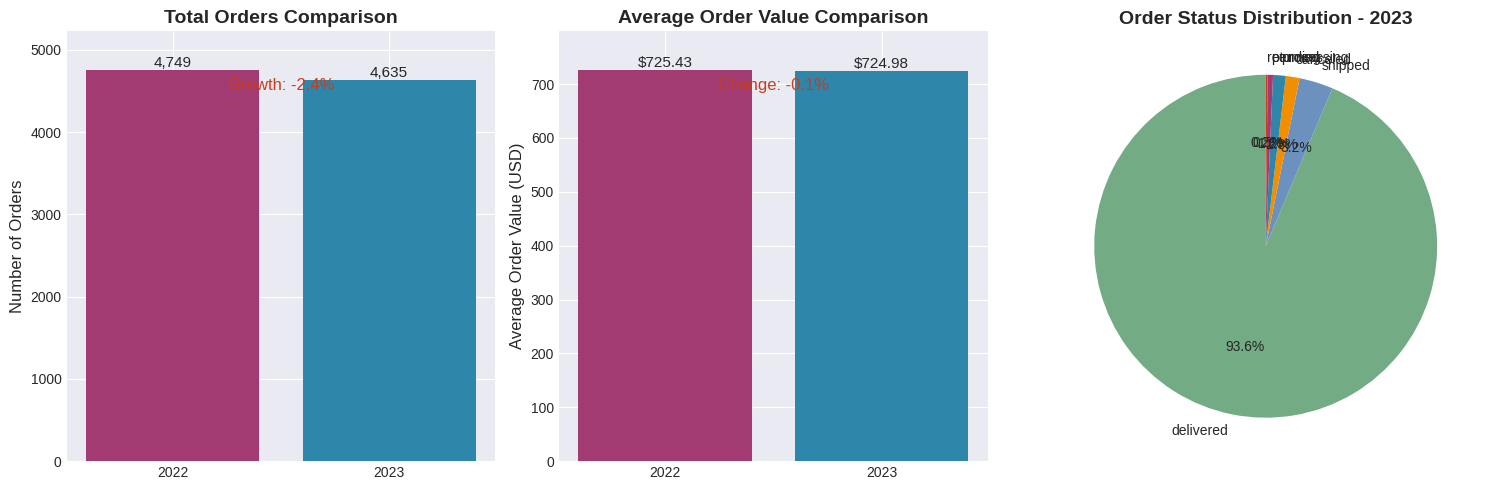


Order Performance Metrics - 2023
Total Orders: 4,625
Average Order Value: $725.22
Median Order Value: $456.52
Average Items per Order: 1.61
Order Value Std Dev: $738.11
Min Order Value: $5.40
Max Order Value: $6107.61


In [8]:
# Calculate order metrics
order_metrics_current = metrics_current.calculate_order_metrics(
    start_date=ANALYSIS_CONFIG['start_date'],
    end_date=ANALYSIS_CONFIG['end_date']
)

order_metrics_previous = BusinessMetrics(sales_data_previous).calculate_order_metrics(
    start_date=ANALYSIS_CONFIG['comparison_start_date'],
    end_date=ANALYSIS_CONFIG['comparison_end_date']
)

# Calculate year-over-year changes
yoy_orders = metrics_all.calculate_yoy_growth(
    current_year=ANALYSIS_CONFIG['current_year'],
    previous_year=ANALYSIS_CONFIG['previous_year'],
    metric='orders'
)

yoy_aov = metrics_all.calculate_yoy_growth(
    current_year=ANALYSIS_CONFIG['current_year'],
    previous_year=ANALYSIS_CONFIG['previous_year'],
    metric='avg_order_value'
)

# Create comparison visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Total Orders Comparison
ax1 = axes[0]
years = [str(ANALYSIS_CONFIG['previous_year']), str(ANALYSIS_CONFIG['current_year'])]
orders = [yoy_orders['previous_value'], yoy_orders['current_value']]
bars1 = ax1.bar(years, orders, color=[COLOR_SCHEME['secondary'], COLOR_SCHEME['primary']])
ax1.set_ylabel('Number of Orders', fontsize=12)
ax1.set_title('Total Orders Comparison', fontsize=14, fontweight='bold')
ax1.set_ylim(0, max(orders) * 1.1)

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}',
             ha='center', va='bottom', fontsize=11)

# Add growth percentage
ax1.text(0.5, max(orders) * 0.95, f"Growth: {yoy_orders['growth_rate']:.1f}%",
         transform=ax1.transData, ha='center', fontsize=12,
         color=COLOR_SCHEME['success'] if yoy_orders['growth_rate'] > 0 else COLOR_SCHEME['danger'])

# Average Order Value Comparison
ax2 = axes[1]
aov_values = [yoy_aov['previous_value'], yoy_aov['current_value']]
bars2 = ax2.bar(years, aov_values, color=[COLOR_SCHEME['secondary'], COLOR_SCHEME['primary']])
ax2.set_ylabel('Average Order Value (USD)', fontsize=12)
ax2.set_title('Average Order Value Comparison', fontsize=14, fontweight='bold')
ax2.set_ylim(0, max(aov_values) * 1.1)

# Add value labels
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'${height:.2f}',
             ha='center', va='bottom', fontsize=11)

# Add growth percentage
ax2.text(0.5, max(aov_values) * 0.95, f"Change: {yoy_aov['growth_rate']:.1f}%",
         transform=ax2.transData, ha='center', fontsize=12,
         color=COLOR_SCHEME['success'] if yoy_aov['growth_rate'] > 0 else COLOR_SCHEME['danger'])

# Order Status Distribution for Current Year
ax3 = axes[2]
all_orders_current = datasets['orders'][datasets['orders']['year'] == ANALYSIS_CONFIG['current_year']]
status_dist = all_orders_current['order_status'].value_counts()
colors_status = [COLOR_SCHEME['success'], COLOR_SCHEME['info'], COLOR_SCHEME['warning'], 
                 COLOR_SCHEME['primary'], COLOR_SCHEME['secondary'], COLOR_SCHEME['danger']]
wedges, texts, autotexts = ax3.pie(status_dist.values, labels=status_dist.index, 
                                    colors=colors_status[:len(status_dist)],
                                    autopct='%1.1f%%', startangle=90)
ax3.set_title(f'Order Status Distribution - {ANALYSIS_CONFIG["current_year"]}', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Display detailed metrics
print(f"\nOrder Performance Metrics - {ANALYSIS_CONFIG['current_year']}")
print("=" * 60)
print(f"Total Orders: {order_metrics_current['total_orders']:,}")
print(f"Average Order Value: ${order_metrics_current['avg_order_value']:.2f}")
print(f"Median Order Value: ${order_metrics_current['median_order_value']:.2f}")
print(f"Average Items per Order: {order_metrics_current['avg_items_per_order']:.2f}")
print(f"Order Value Std Dev: ${order_metrics_current['order_value_std']:.2f}")
print(f"Min Order Value: ${order_metrics_current['min_order_value']:.2f}")
print(f"Max Order Value: ${order_metrics_current['max_order_value']:.2f}")

### 5.3 Product Category Analysis <a id='product-analysis'></a>

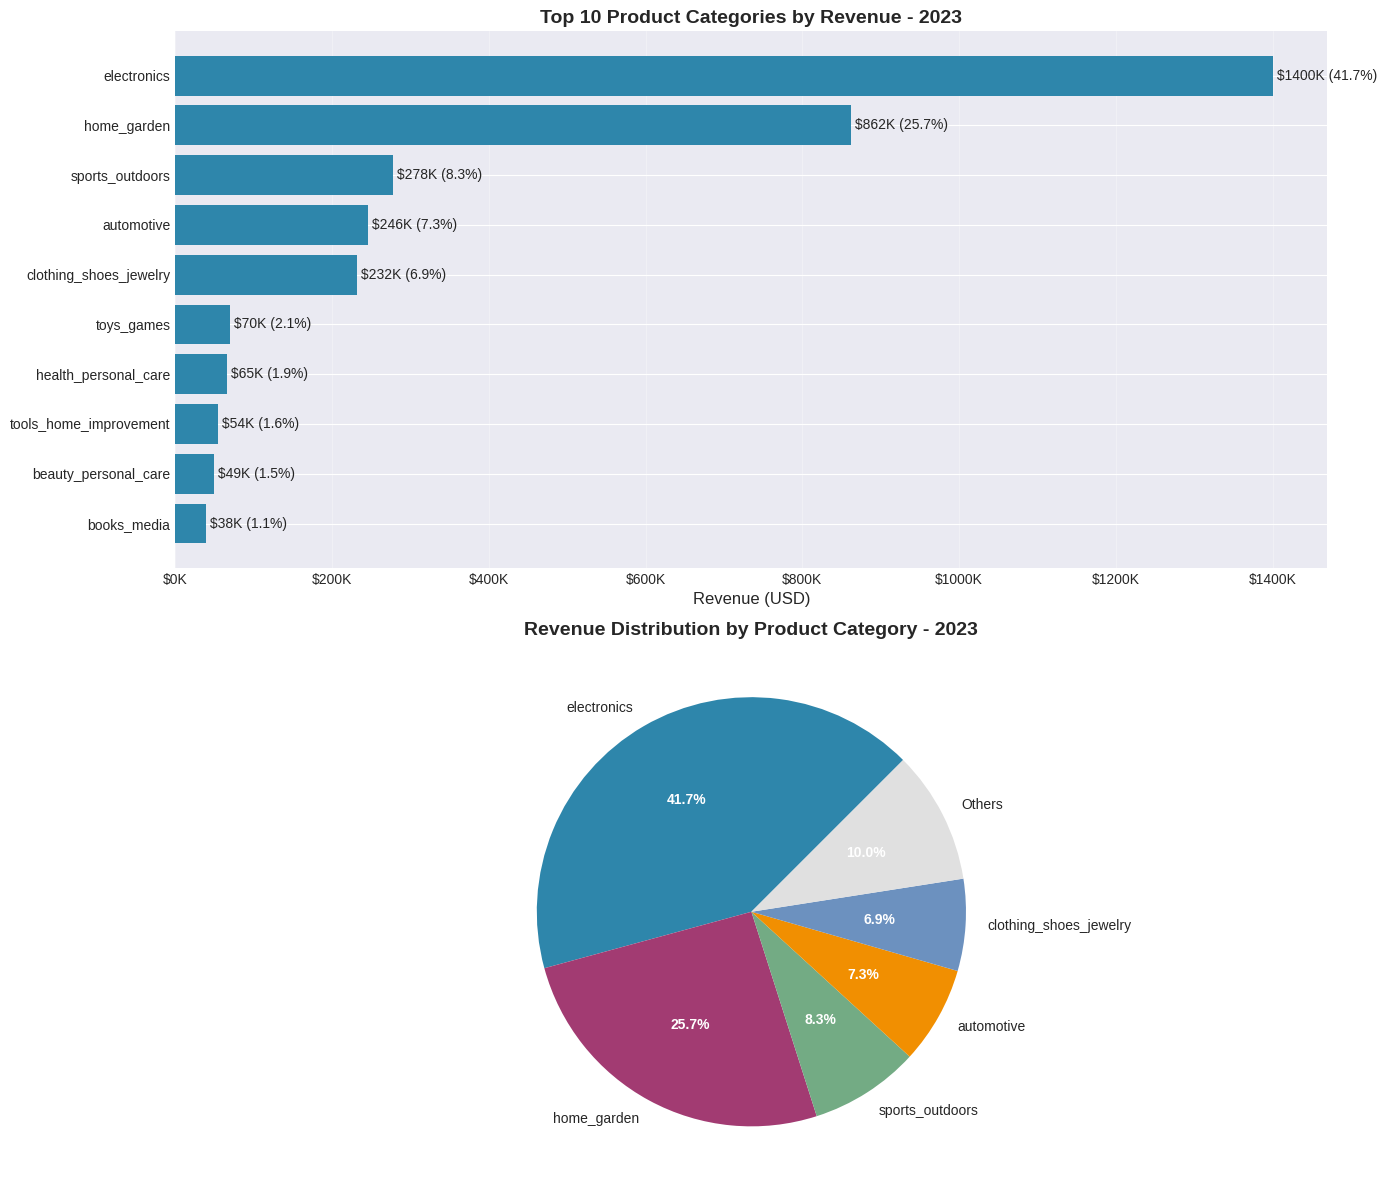


Product Category Performance - 2023
              Category    Revenue Market Share  Orders Avg Price  Products
           electronics $1,399,938        41.7%    1226  $1055.76       773
           home_garden   $861,614        25.7%    1044   $750.53       653
       sports_outdoors   $277,741         8.3%     643   $406.05       379
            automotive   $246,360         7.3%     470   $506.91       291
clothing_shoes_jewelry   $232,046         6.9%     824   $263.99       503
            toys_games    $70,164         2.1%     461   $147.40       282
  health_personal_care    $65,370         1.9%     613   $103.76       363
tools_home_improvement    $54,100         1.6%     212   $248.17       133
  beauty_personal_care    $49,213         1.5%     309   $156.23       175
           books_media    $38,469         1.1%     686    $53.13       420


In [9]:
# Initialize metrics with product data
metrics_products = BusinessMetrics(sales_with_products)

# Calculate product performance
product_performance = metrics_products.calculate_product_performance(
    start_date=ANALYSIS_CONFIG['start_date'],
    end_date=ANALYSIS_CONFIG['end_date'],
    top_n=15
)

# Create product category visualization
fig, axes = plt.subplots(2, 1, figsize=(14, 12))

# Revenue by Category
ax1 = axes[0]
categories = product_performance['product_category_name'][:10]
revenues = product_performance['revenue'][:10]

bars = ax1.barh(range(len(categories)), revenues, color=COLOR_SCHEME['primary'])
ax1.set_yticks(range(len(categories)))
ax1.set_yticklabels(categories)
ax1.set_xlabel('Revenue (USD)', fontsize=12)
ax1.set_title(f'Top 10 Product Categories by Revenue - {ANALYSIS_CONFIG["current_year"]}', 
             fontsize=14, fontweight='bold')
ax1.invert_yaxis()

# Add value labels
for i, (bar, revenue, share) in enumerate(zip(bars, revenues, product_performance['revenue_share'][:10])):
    ax1.text(revenue, bar.get_y() + bar.get_height()/2,
             f' ${revenue/1000:.0f}K ({share:.1f}%)',
             va='center', fontsize=10)

ax1.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))
ax1.grid(True, alpha=0.3, axis='x')

# Product Mix Analysis
ax2 = axes[1]
top_5_categories = product_performance.head(5)
other_revenue = product_performance.iloc[5:]['revenue'].sum()

# Create data for pie chart
pie_labels = list(top_5_categories['product_category_name']) + ['Others']
pie_values = list(top_5_categories['revenue']) + [other_revenue]
colors_pie = [COLOR_SCHEME['primary'], COLOR_SCHEME['secondary'], COLOR_SCHEME['success'],
             COLOR_SCHEME['warning'], COLOR_SCHEME['info'], '#E0E0E0']

wedges, texts, autotexts = ax2.pie(pie_values, labels=pie_labels, colors=colors_pie,
                                    autopct='%1.1f%%', startangle=45)
ax2.set_title(f'Revenue Distribution by Product Category - {ANALYSIS_CONFIG["current_year"]}',
             fontsize=14, fontweight='bold')

# Make percentage text more readable
for autotext in autotexts:
    autotext.set_fontsize(10)
    autotext.set_fontweight('bold')
    autotext.set_color('white')

plt.tight_layout()
plt.show()

# Display detailed product metrics
print(f"\nProduct Category Performance - {ANALYSIS_CONFIG['current_year']}")
print("=" * 100)
display_df = product_performance[['product_category_name', 'revenue', 'revenue_share', 
                                  'order_count', 'avg_price', 'unique_products']].head(10).copy()
display_df['revenue'] = display_df['revenue'].apply(lambda x: f'${x:,.0f}')
display_df['revenue_share'] = display_df['revenue_share'].apply(lambda x: f'{x:.1f}%')
display_df['avg_price'] = display_df['avg_price'].apply(lambda x: f'${x:.2f}')
display_df.columns = ['Category', 'Revenue', 'Market Share', 'Orders', 'Avg Price', 'Products']
print(display_df.to_string(index=False))

### 5.4 Geographic Distribution <a id='geographic-analysis'></a>

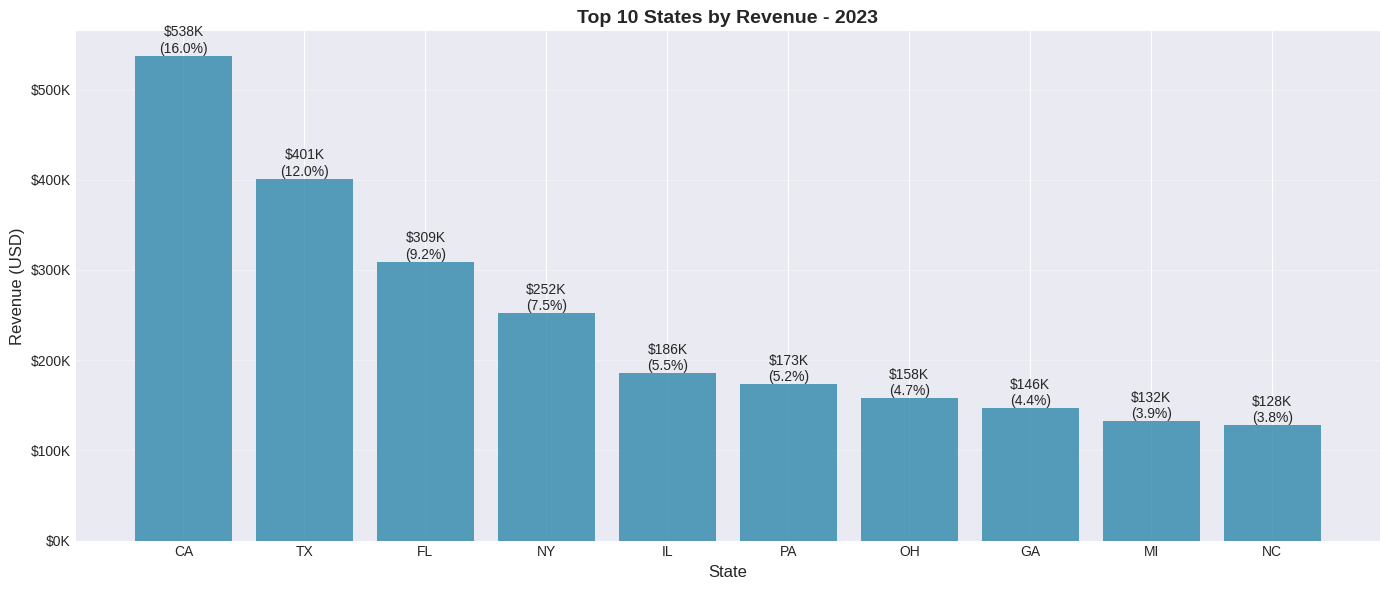


Geographic Performance - Top 10 States (2023)
State  Revenue Market Share  Orders  Customers     AOV
   CA $537,609        16.0%     768        581 $700.01
   TX $401,274        12.0%     559        436 $717.84
   FL $309,157         9.2%     430        332 $718.97
   NY $251,912         7.5%     382        285 $659.46
   IL $185,836         5.5%     259        190 $717.51
   PA $173,261         5.2%     225        172 $770.05
   OH $157,620         4.7%     200        151 $788.10
   GA $146,415         4.4%     190        145 $770.60
   MI $132,326         3.9%     210        164 $630.12
   NC $128,315         3.8%     177        135 $724.94


In [10]:
# Initialize metrics with geographic data
metrics_geography = BusinessMetrics(sales_with_geography)

# Calculate geographic performance
geographic_performance = metrics_geography.calculate_geographic_performance(
    start_date=ANALYSIS_CONFIG['start_date'],
    end_date=ANALYSIS_CONFIG['end_date']
)

# Create interactive choropleth map
fig = px.choropleth(
    geographic_performance,
    locations='customer_state',
    color='revenue',
    locationmode='USA-states',
    scope='usa',
    title=f'Revenue by State - {ANALYSIS_CONFIG["current_year"]}',
    color_continuous_scale='Blues',
    labels={'revenue': 'Revenue (USD)', 'customer_state': 'State'},
    hover_data=['order_count', 'unique_customers', 'avg_order_value']
)

fig.update_layout(
    title_font_size=16,
    title_x=0.5,
    geo=dict(
        showframe=False,
        showcoastlines=True,
        projection_type='albers usa'
    ),
    height=600
)

fig.show()

# Top states bar chart
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

top_states = geographic_performance.head(10)
bars = ax.bar(range(len(top_states)), top_states['revenue'], 
              color=COLOR_SCHEME['primary'], alpha=0.8)
ax.set_xticks(range(len(top_states)))
ax.set_xticklabels(top_states['customer_state'], rotation=0)
ax.set_xlabel('State', fontsize=12)
ax.set_ylabel('Revenue (USD)', fontsize=12)
ax.set_title(f'Top 10 States by Revenue - {ANALYSIS_CONFIG["current_year"]}', 
            fontsize=14, fontweight='bold')

# Add value labels and market share
for i, (bar, revenue, share) in enumerate(zip(bars, top_states['revenue'], top_states['revenue_share'])):
    ax.text(bar.get_x() + bar.get_width()/2, revenue,
            f'${revenue/1000:.0f}K\n({share:.1f}%)',
            ha='center', va='bottom', fontsize=10)

ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Display state metrics table
print(f"\nGeographic Performance - Top 10 States ({ANALYSIS_CONFIG['current_year']})")
print("=" * 100)
display_geo = top_states[['customer_state', 'revenue', 'revenue_share', 'order_count', 
                          'unique_customers', 'avg_order_value']].copy()
display_geo['revenue'] = display_geo['revenue'].apply(lambda x: f'${x:,.0f}')
display_geo['revenue_share'] = display_geo['revenue_share'].apply(lambda x: f'{x:.1f}%')
display_geo['avg_order_value'] = display_geo['avg_order_value'].apply(lambda x: f'${x:.2f}')
display_geo.columns = ['State', 'Revenue', 'Market Share', 'Orders', 'Customers', 'AOV']
print(display_geo.to_string(index=False))

### 5.5 Customer Experience Metrics <a id='customer-experience'></a>

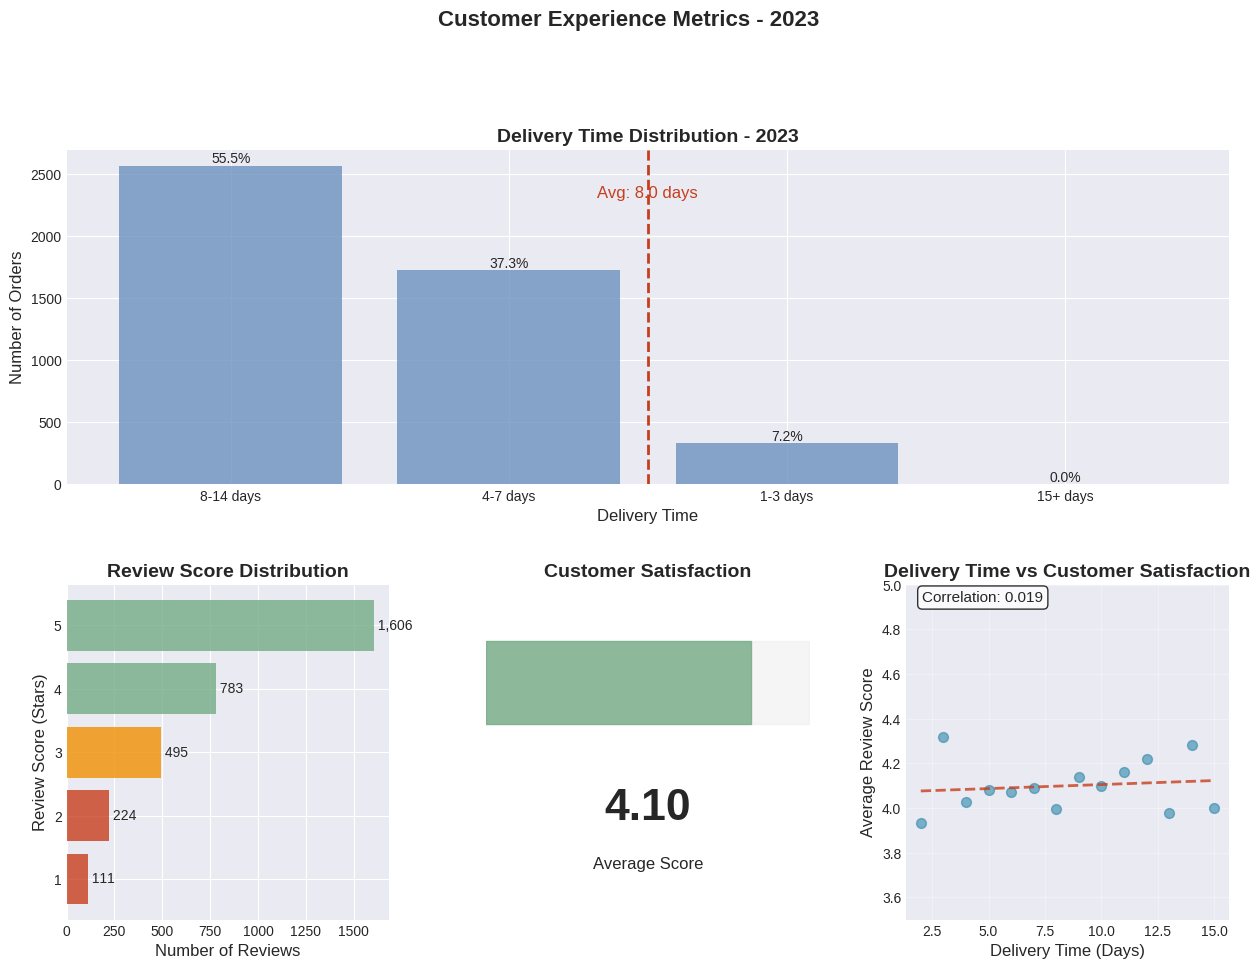


Customer Experience Summary - 2023

Delivery Performance:
  Average Delivery Time: 8.0 days
  Median Delivery Time: 8 days
  Fastest Delivery: 2 days
  Slowest Delivery: 15 days

Review Metrics:
  Average Review Score: 4.10 / 5.0
  5-Star Reviews: 49.9%
  4-5 Star Reviews: 74.2%
  1-2 Star Reviews: 10.4%
  Total Reviews: 3,219


In [11]:
# Calculate delivery performance
delivery_metrics = metrics_current.calculate_delivery_performance(
    start_date=ANALYSIS_CONFIG['start_date'],
    end_date=ANALYSIS_CONFIG['end_date']
)

# Calculate review metrics
review_metrics = metrics_current.calculate_review_metrics(
    start_date=ANALYSIS_CONFIG['start_date'],
    end_date=ANALYSIS_CONFIG['end_date']
)

# Create customer experience visualization
fig = plt.figure(figsize=(15, 10))
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

# Delivery Time Distribution
ax1 = fig.add_subplot(gs[0, :])
if 'delivery_distribution' in delivery_metrics:
    delivery_cats = list(delivery_metrics['delivery_distribution']['counts'].keys())
    delivery_values = list(delivery_metrics['delivery_distribution']['counts'].values())
    bars = ax1.bar(delivery_cats, delivery_values, color=COLOR_SCHEME['info'], alpha=0.8)
    ax1.set_xlabel('Delivery Time', fontsize=12)
    ax1.set_ylabel('Number of Orders', fontsize=12)
    ax1.set_title(f'Delivery Time Distribution - {ANALYSIS_CONFIG["current_year"]}', 
                 fontsize=14, fontweight='bold')
    
    # Add percentage labels
    for bar, pct in zip(bars, delivery_metrics['delivery_distribution']['percentages'].values()):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{pct:.1f}%',
                ha='center', va='bottom', fontsize=10)
    
    # Add average delivery time annotation
    avg_delivery = delivery_metrics['avg_delivery_days']
    ax1.axvline(x=1.5, color=COLOR_SCHEME['danger'], linestyle='--', linewidth=2)
    ax1.text(1.5, max(delivery_values) * 0.9, 
            f'Avg: {avg_delivery:.1f} days',
            ha='center', fontsize=12, color=COLOR_SCHEME['danger'])

# Review Score Distribution
ax2 = fig.add_subplot(gs[1, 0])
if 'review_distribution' in review_metrics:
    scores = list(review_metrics['review_distribution'].keys())
    counts = list(review_metrics['review_distribution'].values())
    colors_reviews = [COLOR_SCHEME['danger'] if s <= 2 else 
                     COLOR_SCHEME['warning'] if s == 3 else 
                     COLOR_SCHEME['success'] for s in scores]
    
    bars = ax2.barh(scores, counts, color=colors_reviews, alpha=0.8)
    ax2.set_xlabel('Number of Reviews', fontsize=12)
    ax2.set_ylabel('Review Score (Stars)', fontsize=12)
    ax2.set_title('Review Score Distribution', fontsize=14, fontweight='bold')
    ax2.set_yticks(scores)
    
    # Add count labels
    for bar, count in zip(bars, counts):
        ax2.text(count, bar.get_y() + bar.get_height()/2,
                f' {count:,}',
                va='center', fontsize=10)

# Review Metrics Summary
ax3 = fig.add_subplot(gs[1, 1])
if review_metrics and 'avg_review_score' in review_metrics:
    # Create gauge chart for average review score
    avg_score = review_metrics['avg_review_score']
    
    # Create semi-circle gauge
    theta = np.linspace(0, np.pi, 100)
    r_outer = 1
    r_inner = 0.7
    
    # Background arc
    ax3.fill_between(theta, r_inner, r_outer, color='#E0E0E0', alpha=0.3)
    
    # Score arc
    score_theta = np.linspace(0, np.pi * (avg_score/5), 100)
    color = COLOR_SCHEME['danger'] if avg_score < 3 else COLOR_SCHEME['warning'] if avg_score < 4 else COLOR_SCHEME['success']
    ax3.fill_between(score_theta, r_inner, r_outer, color=color, alpha=0.8)
    
    ax3.set_xlim(0, np.pi)
    ax3.set_ylim(0, 1.2)
    ax3.axis('off')
    
    # Add score text
    ax3.text(np.pi/2, 0.4, f'{avg_score:.2f}', 
            ha='center', va='center', fontsize=32, fontweight='bold')
    ax3.text(np.pi/2, 0.2, 'Average Score', 
            ha='center', va='center', fontsize=12)
    ax3.set_title('Customer Satisfaction', fontsize=14, fontweight='bold')

# Delivery vs Review Correlation
ax4 = fig.add_subplot(gs[1, 2])
if 'delivery_days' in sales_with_reviews.columns and 'review_score' in sales_with_reviews.columns:
    # Group by delivery days and calculate average review score
    delivery_review = sales_with_reviews.groupby('delivery_days')['review_score'].mean().reset_index()
    delivery_review = delivery_review[delivery_review['delivery_days'] <= 20]  # Filter outliers
    
    ax4.scatter(delivery_review['delivery_days'], delivery_review['review_score'], 
               alpha=0.6, s=50, color=COLOR_SCHEME['primary'])
    
    # Add trend line
    z = np.polyfit(delivery_review['delivery_days'], delivery_review['review_score'], 1)
    p = np.poly1d(z)
    ax4.plot(delivery_review['delivery_days'], p(delivery_review['delivery_days']), 
            color=COLOR_SCHEME['danger'], linestyle='--', linewidth=2, alpha=0.8)
    
    ax4.set_xlabel('Delivery Time (Days)', fontsize=12)
    ax4.set_ylabel('Average Review Score', fontsize=12)
    ax4.set_title('Delivery Time vs Customer Satisfaction', fontsize=14, fontweight='bold')
    ax4.set_ylim(3.5, 5)
    ax4.grid(True, alpha=0.3)
    
    # Add correlation coefficient
    if 'delivery_review_correlation' in review_metrics:
        corr = review_metrics['delivery_review_correlation']
        ax4.text(0.05, 0.95, f'Correlation: {corr:.3f}',
                transform=ax4.transAxes, fontsize=11,
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.suptitle(f'Customer Experience Metrics - {ANALYSIS_CONFIG["current_year"]}', 
            fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Display detailed metrics
print(f"\nCustomer Experience Summary - {ANALYSIS_CONFIG['current_year']}")
print("=" * 60)
print("\nDelivery Performance:")
if 'avg_delivery_days' in delivery_metrics:
    print(f"  Average Delivery Time: {delivery_metrics['avg_delivery_days']:.1f} days")
    print(f"  Median Delivery Time: {delivery_metrics['median_delivery_days']:.0f} days")
    print(f"  Fastest Delivery: {delivery_metrics['min_delivery_days']:.0f} days")
    print(f"  Slowest Delivery: {delivery_metrics['max_delivery_days']:.0f} days")
    if 'on_time_rate' in delivery_metrics and delivery_metrics['on_time_rate']:
        print(f"  On-Time Delivery Rate: {delivery_metrics['on_time_rate']:.1f}%")

print("\nReview Metrics:")
if 'avg_review_score' in review_metrics:
    print(f"  Average Review Score: {review_metrics['avg_review_score']:.2f} / 5.0")
    print(f"  5-Star Reviews: {review_metrics['pct_5_star']:.1f}%")
    print(f"  4-5 Star Reviews: {review_metrics['pct_4_5_star']:.1f}%")
    print(f"  1-2 Star Reviews: {review_metrics['pct_1_2_star']:.1f}%")
    print(f"  Total Reviews: {review_metrics['total_reviews']:,}")

## 6. Key Insights & Summary <a id='summary'></a>

In [12]:
# Generate executive summary
print(f"\nEXECUTIVE SUMMARY - E-COMMERCE PERFORMANCE {ANALYSIS_CONFIG['current_year']}")
print("=" * 80)

# Revenue Summary
print("\nREVENUE PERFORMANCE:")
print(f"  • Total Revenue: ${yoy_revenue['current_value']:,.0f}")
revenue_trend = "increased" if yoy_revenue['growth_rate'] > 0 else "decreased"
print(f"  • Year-over-Year: {revenue_trend} by {abs(yoy_revenue['growth_rate']):.1f}%")
print(f"  • Monthly Average Growth: {monthly_metrics['revenue_mom_growth'].mean():.1f}%")

# Order Performance
print("\nORDER METRICS:")
print(f"  • Total Orders: {order_metrics_current['total_orders']:,}")
print(f"  • Average Order Value: ${order_metrics_current['avg_order_value']:.2f}")
order_trend = "increased" if yoy_orders['growth_rate'] > 0 else "decreased"
print(f"  • Order Volume: {order_trend} by {abs(yoy_orders['growth_rate']):.1f}% YoY")

# Product Performance
print("\nTOP PRODUCT CATEGORIES:")
for i, row in product_performance.head(3).iterrows():
    print(f"  {i+1}. {row['product_category_name']}: ${row['revenue']:,.0f} ({row['revenue_share']:.1f}% of revenue)")

# Geographic Performance
print("\nTOP MARKETS BY STATE:")
for i, row in geographic_performance.head(3).iterrows():
    print(f"  {i+1}. {row['customer_state']}: ${row['revenue']:,.0f} ({row['revenue_share']:.1f}% of revenue)")

# Customer Experience
print("\nCUSTOMER EXPERIENCE:")
if 'avg_review_score' in review_metrics:
    print(f"  • Customer Satisfaction: {review_metrics['avg_review_score']:.2f}/5.0")
    print(f"  • Positive Reviews (4-5 stars): {review_metrics['pct_4_5_star']:.1f}%")
if 'avg_delivery_days' in delivery_metrics:
    print(f"  • Average Delivery Time: {delivery_metrics['avg_delivery_days']:.1f} days")

# Key Observations
print("\nKEY OBSERVATIONS:")

# Revenue observation
if yoy_revenue['growth_rate'] > 5:
    print("  ✓ Strong revenue growth indicates healthy business expansion")
elif yoy_revenue['growth_rate'] > 0:
    print("  ✓ Modest revenue growth shows stable business performance")
else:
    print("  ⚠ Revenue decline requires attention to growth strategies")

# Order value observation
if yoy_aov['growth_rate'] > 0:
    print("  ✓ Increasing average order value suggests successful upselling")
else:
    print("  ⚠ Declining average order value may indicate pricing pressure")

# Customer satisfaction observation
if 'avg_review_score' in review_metrics:
    if review_metrics['avg_review_score'] >= 4.0:
        print("  ✓ High customer satisfaction scores indicate strong service quality")
    else:
        print("  ⚠ Customer satisfaction below 4.0 requires service improvements")

# Delivery observation
if 'avg_delivery_days' in delivery_metrics:
    if delivery_metrics['avg_delivery_days'] <= 7:
        print("  ✓ Delivery times meet industry standards")
    else:
        print("  ⚠ Extended delivery times may impact customer satisfaction")

print("\n" + "=" * 80)
print(f"Report Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Analysis Period: {ANALYSIS_CONFIG['start_date']} to {ANALYSIS_CONFIG['end_date']}")


EXECUTIVE SUMMARY - E-COMMERCE PERFORMANCE 2023

REVENUE PERFORMANCE:
  • Total Revenue: $3,360,295
  • Year-over-Year: decreased by 2.5%
  • Monthly Average Growth: -0.4%

ORDER METRICS:
  • Total Orders: 4,625
  • Average Order Value: $725.22
  • Order Volume: decreased by 2.4% YoY

TOP PRODUCT CATEGORIES:
  1. electronics: $1,399,938 (41.7% of revenue)
  2. home_garden: $861,614 (25.7% of revenue)
  3. sports_outdoors: $277,741 (8.3% of revenue)

TOP MARKETS BY STATE:
  1. CA: $537,609 (16.0% of revenue)
  2. TX: $401,274 (12.0% of revenue)
  3. FL: $309,157 (9.2% of revenue)

CUSTOMER EXPERIENCE:
  • Customer Satisfaction: 4.10/5.0
  • Positive Reviews (4-5 stars): 74.2%
  • Average Delivery Time: 8.0 days

KEY OBSERVATIONS:
  ⚠ Revenue decline requires attention to growth strategies
  ⚠ Declining average order value may indicate pricing pressure
  ✓ High customer satisfaction scores indicate strong service quality
  ⚠ Extended delivery times may impact customer satisfaction

Repo